# Run Simulations

## Import relevant libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from configparser import ConfigParser

import gym
import gym_anytrading

from gym_anytrading.envs import CryptoEnvLogBLSH

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [2]:
%matplotlib inline

## Get values from the config file

In [3]:
configur = ConfigParser()
config_file_name = "config_01.ini"
print (configur.read(os.path.join('config_files', config_file_name)))

['config_files/config_01.ini']


In [4]:
ccy = configur.get('data', 'ccy')
data_frequency = configur.get('data', 'data_frequency')

window_size = configur.getint('environment', 'window_size')
start_date = configur.get('environment', 'start_date')
mid_date = configur.get('environment', 'mid_date')
end_date = configur.get('environment', 'end_date')
list_features = configur.get('environment', 'features').split(',')
target = configur.get('environment', 'target')

num_of_simulations = configur.getint('simulation', 'num_of_simulations')

In [5]:
def get_and_process_data(ccy, data_frequency):
    try:
        
        # Get the data
        filename_data = 'binance_' + ccy + "_" + data_frequency + '_from_2017_01_01_to_2022_12_31_candlesticks_signals_processed_technical_indicators_and_crypto_index_log.csv'
        fullpath_data = os.path.join('../../data/50_log/', filename_data)
        df = pd.read_csv(fullpath_data)

        # Converting Date Column to DateTime Type
        df['Date'] = pd.to_datetime(df['formatted_open_time'])

        # Setting the column as index
        df.set_index('Date', inplace=True)

        return df

    except Exception as e:
        print(e)

In [6]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, target].to_numpy()[start:end]
    signal_features = env.df.loc[:, list_features].to_numpy()[start:end]
    return prices, signal_features

class MyEnv(CryptoEnvLogBLSH):
    _process_data = my_process_data

In [7]:
df = get_and_process_data(ccy, data_frequency)

In [8]:
start_date_id = int(df.index.get_loc(start_date))
mid_date_id = int(df.index.get_loc(mid_date))
end_date_id = int(df.index.get_loc(end_date))

In [9]:
list_models = ['A2C', 'PPO', 'DQN']

path_tensorboard = os.path.join("tensorboard", config_file_name.replace(".ini", ""))

df_sim_results = pd.DataFrame()

for model_name in list_models:

    #setting up our environment for training 
    env_maker = lambda: MyEnv(df=df, frame_bound=(start_date_id,mid_date_id), window_size=window_size)
    env = DummyVecEnv([env_maker])

    if(model_name == 'A2C'):
        model = A2C('MlpPolicy', env, verbose=0, tensorboard_log=path_tensorboard) 
    elif(model_name == 'PPO'):
        model = PPO('MlpPolicy', env, batch_size=1024, verbose=0, tensorboard_log=path_tensorboard)
    elif(model_name == 'DQN'):
        model = DQN('MlpPolicy', env, batch_size=1024, verbose=0, tensorboard_log=path_tensorboard)

    #setting the learning timesteps
    model.learn(total_timesteps=(mid_date_id - start_date_id))  

    df_sim_results_temp = pd.DataFrame(columns=['total_reward_cash', 'total_profit_percentage', 'num_of_trades'])

    for i in range(num_of_simulations):   
        
        # Check the progress
        if(i % 10 == 0):
            print(i)

        env = MyEnv(df=df, frame_bound=(mid_date_id,end_date_id), window_size=window_size)
        #Setting up the Agent Environment
        obs = env.reset()
        while True: 
            obs = obs[np.newaxis, ...]
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            if done:
                df_sim_results_temp = df_sim_results_temp.append(info, ignore_index=True, sort=False)
                break

    df_sim_results_temp['ccy'] = ccy
    df_sim_results_temp['data_frequency'] = data_frequency
    df_sim_results_temp['window_size'] = window_size
    df_sim_results_temp['start_date'] = start_date
    df_sim_results_temp['mid_date'] = mid_date
    df_sim_results_temp['end_date'] = end_date
    df_sim_results_temp['list_features'] = str(list_features)
    df_sim_results_temp['model_type'] = model_name 
    df_sim_results_temp['num_of_simulations'] = num_of_simulations   

    df_sim_results = pd.concat([df_sim_results, df_sim_results_temp], axis=0)      

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
5

## Results Analysis

### Pre-process results

In [10]:
df_sim_results = df_sim_results.reset_index(drop=True)

In [11]:
df_sim_results = df_sim_results.drop_duplicates()

### Display the results

In [12]:
#df_sim_results.sample(10)

### Plots

In [13]:
sns.set(rc={"figure.figsize":(15, 10)})

str_title = f'ccy:{ccy} | data_frequency:{data_frequency} | window_size:{window_size} | start_run_date:{mid_date} | end_run_date:{end_date} | lenght list_features:{len(list_features)} | num_of_simulations:{num_of_simulations}'

file_export_plot_sim_results = config_file_name.replace(".ini", ".png")

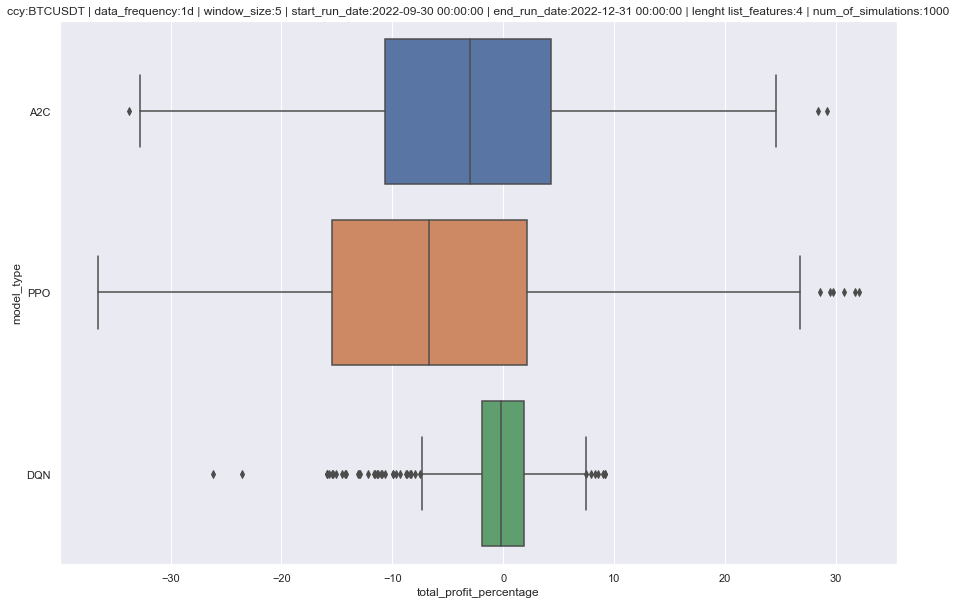

In [14]:
sns.boxplot(data=df_sim_results, x="total_profit_percentage", y="model_type").set(title=str_title)
plt.savefig(os.path.join('results', 'box_plot_' + file_export_plot_sim_results))


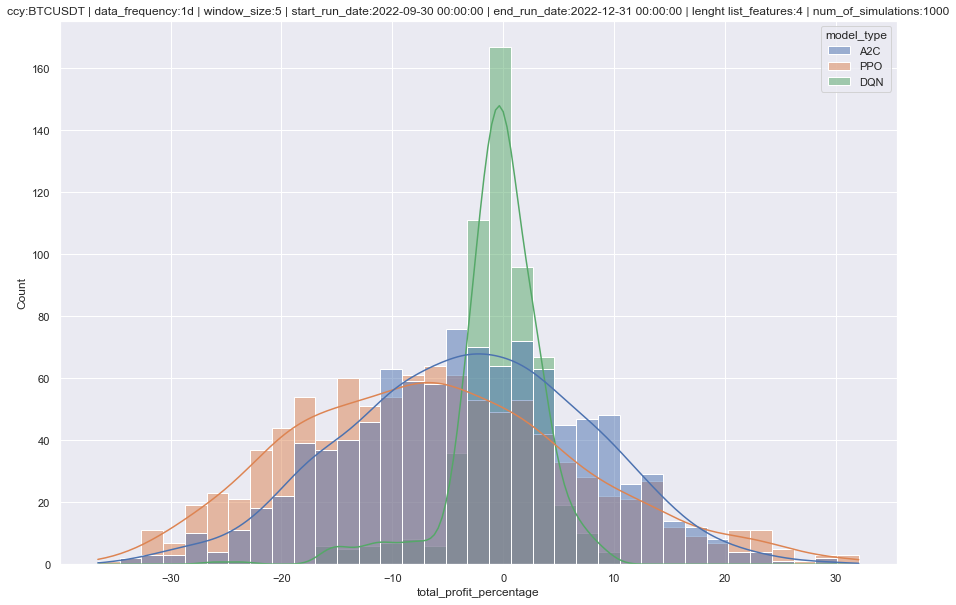

In [15]:
sns.histplot(data=df_sim_results, x="total_profit_percentage", hue="model_type", kde=True).set(title=str_title)
plt.savefig(os.path.join('results', 'hist_plot_' + file_export_plot_sim_results))

## Export results

In [16]:
file_export_sim_results = config_file_name.replace(".ini", ".csv")
fullpath_export_sim_results = os.path.join('results', 'sim_results_' + file_export_sim_results)

In [17]:
df_sim_results.to_csv(fullpath_export_sim_results)